In [235]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from konlpy.tag import Okt; t = Okt()
import numpy as np
from collections import Counter
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer; tokenizer = Tokenizer()
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import re

import warnings
warnings.filterwarnings(action = 'ignore')

In [236]:
# 데이터 불러오기
review_data = pd.read_csv('./review_data.csv')
review_data.head()

,name,score,review
0,카페디퍼,80,주차도 할겸 따뜻한라떼 한잔 마시는데 중년의 사장님이 샷이 잘못되었다며 다시 가져다...
1,롯데시네마 도곡,100,역시 새 영화관이라 그런지 시설이 좋습니다\n공기도 쾌적하고 주말에 차가 많은 거 ...
2,롯데시네마 도곡,100,깔끔하네요
3,롯데시네마 도곡,100,"인간적으로 롯데시네마 ""매봉""이라고 하자....\n도곡역 갔다 옴"
4,이소젠네타,100,갠적으로 오복수산보다 훨씬 맛있었음 ..\n진짜 강추


In [237]:
# 결측값 확인
review_data.isna().sum()

name      0
score     0
review    0
dtype: int64

In [238]:
# 80점 이상이 긍정이란 가정하에 긍, 부정 라벨링
review_data['label'] = [1 if i>60 else 0 for i in review_data['score']]
review_data

,name,score,review,label
0,카페디퍼,80,주차도 할겸 따뜻한라떼 한잔 마시는데 중년의 사장님이 샷이 잘못되었다며 다시 가져다...,1
1,롯데시네마 도곡,100,역시 새 영화관이라 그런지 시설이 좋습니다\n공기도 쾌적하고 주말에 차가 많은 거 ...,1
2,롯데시네마 도곡,100,깔끔하네요,1
3,롯데시네마 도곡,100,"인간적으로 롯데시네마 ""매봉""이라고 하자....\n도곡역 갔다 옴",1
4,이소젠네타,100,갠적으로 오복수산보다 훨씬 맛있었음 ..\n진짜 강추,1
...,...,...,...,...
1192,원포셰,100,동네 최애 디저트집,1
1193,바이칼리아,60,공간은 예쁘고 쾌적해서 좋습니다. 지금 정도 날씨에는 야외석을 추천\n디저트랑 음료...,0
1194,바이칼리아,60,2층 대형카페인데 사람 많지 않고 분위기 좋고 컬러감이 좋아요! 가격은 위치가 위치...,0
1195,바이칼리아,60,최고예요!! 사장님도 너무 친절하세요😎,0


<AxesSubplot:>

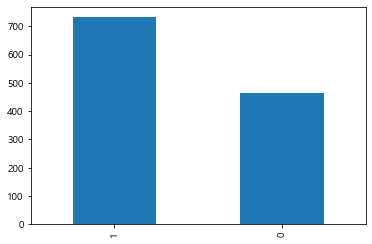

In [239]:
# 긍, 부정 분포
review_data['label'].value_counts().plot(kind='bar')

In [240]:
# 한글만 남기기
review_data['review'] = review_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")

# 불용어 리스트
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

# 토큰화 후 불용어 제거
review_data['tokenized'] = review_data['review'].apply(t.morphs)
review_data['tokenized'] = review_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

review_data.head()

,name,score,review,label,tokenized
0,카페디퍼,80,주차도할겸따뜻한라떼한잔마시는데중년의사장님이샷이잘못되었다며다시가져다주시네요나중라떼가더...,1,"[주차, 할, 겸, 따뜻한, 라떼, 한잔, 마시는데, 중년, 사장, 님, 샷, 잘못..."
1,롯데시네마 도곡,100,역시새영화관이라그런지시설이좋습니다공기도쾌적하고주말에차가많은거빼곤다마음에듭니다,1,"[역시, 새, 영화관, 이라, 그런지, 시설, 좋습니다, 공기, 쾌적하고주말에, 차..."
2,롯데시네마 도곡,100,깔끔하네요,1,[깔끔하네요]
3,롯데시네마 도곡,100,인간적으로롯데시네마매봉이라고하자도곡역갔다옴,1,"[인간, 적, 으로, 롯데, 시, 마매, 봉, 이라고, 하자, 도곡역, 갔다, 옴]"
4,이소젠네타,100,갠적으로오복수산보다훨씬맛있었음진짜강추,1,"[갠, 적, 으로, 오복, 수산, 보다, 훨씬, 맛있었음, 진짜, 강추]"


In [241]:
# 긍정과 부정에 따른 단어의 빈도수
positive_words = np.hstack(review_data[review_data.label==1]['tokenized'].values)
negative_words = np.hstack(review_data[review_data.label==0]['tokenized'].values)

In [242]:
# 부정 리뷰에 많이 나온 토큰
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('맛', 110), ('너무', 78), ('보기', 73), ('더', 66), ('분', 64), ('커피', 57), ('에서', 56), ('직원', 52), ('하고', 46), ('곳', 42), ('로', 41), ('메뉴', 39), ('손님', 39), ('사장', 39), ('요', 38), ('으로', 38), ('주문', 36), ('그냥', 35), ('진짜', 34), ('만', 34)]


In [243]:
# 긍정 리뷰에 많이 나온 토큰
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('너무', 153), ('맛', 132), ('커피', 97), ('맛있어요', 88), ('님', 85), ('사장', 75), ('더', 72), ('보기', 65), ('진짜', 64), ('가격', 59), ('분위기', 57), ('만', 56), ('에서', 51), ('좋아요', 49), ('로', 49), ('으로', 45), ('곳', 44), ('분', 43), ('적', 42), ('직원', 42)]


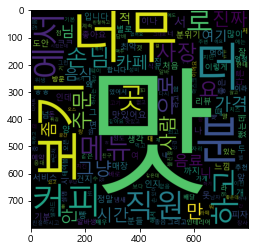

In [244]:
# 부정 워드클라우드
wc = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', width=400, 
    height=400, scale=2.0, max_font_size=250
)
gen = wc.generate_from_frequencies(negative_word_count)
plt.figure()
plt.imshow(gen)

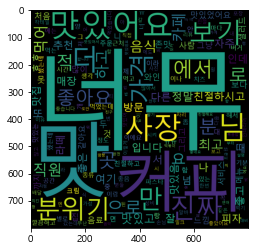

In [245]:
# 긍정 워드클라우드
gen = wc.generate_from_frequencies(positive_word_count)
plt.figure()
plt.imshow(gen)

긍정 리뷰의 평균 길이 : 15.504098360655737
부정 리뷰의 평균 길이 : 20.946236559139784


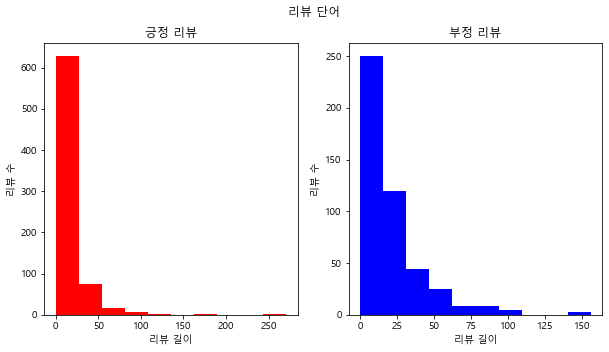

In [246]:
# 그래프 한글 깨짐
plt.rc('font', family='Malgun Gothic')

# 긍정과 부정에 따른 길이 분포
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
text_len = review_data[review_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('긍정 리뷰')
ax1.set_xlabel('리뷰 길이')
ax1.set_ylabel('리뷰 수')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = review_data[review_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('부정 리뷰')
fig.suptitle('리뷰 단어')
ax2.set_xlabel('리뷰 길이')
ax2.set_ylabel('리뷰 수')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [247]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    review_data['tokenized'], review_data['label'], test_size=0.15, random_state=3
)

In [248]:
tokenizer.fit_on_texts(X_train)
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총 합

# 단어와 빈도수를 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어 등장 빈도수가 threshold보다 작으면
    if value<threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합의 크기 :',total_cnt)
print('등장 빈도 %s번 이하인 희귀 단어 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합의 희귀 단어 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도의 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합의 크기 : 6198
등장 빈도 1번 이하인 희귀 단어 수: 4084
단어 집합의 희귀 단어 비율: 65.89222329783802
전체 등장 빈도의 희귀 단어 등장 빈도 비율: 22.781279634071513


In [249]:
# vocab_size = 단어 집합+(패딩 토큰+OOV 토큰)
vocab_size = total_cnt-rare_cnt+2
vocab_size

2116

In [250]:
# 시퀀스 형태로 변환
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [251]:
print(X_train[:3])

[[466, 558, 240, 1269, 50, 558, 919, 1270, 241, 919, 1271, 920, 1, 1, 691, 30, 467, 24, 406, 692, 919, 1, 466, 1, 468, 1, 1, 242, 15, 1, 469, 1272, 1, 1, 559, 1, 470, 268, 1, 1, 121, 471, 560, 1], [407, 59, 1, 921, 693, 1, 1, 308], [1, 472, 16, 132, 19, 1, 53, 1273, 309, 1, 81, 310, 1, 243, 473, 561, 168]]


In [252]:
print(tokenizer.sequences_to_texts(X_train[:3]))

['이드 잔 시켰는데 그중 두 잔 초파리 나왔어요 주변 초파리 마리 없었는데 OOV OOV 같고 음료 뒤 적 거리 다가 초파리 OOV 이드 OOV 들어간 OOV OOV 다시 만 OOV 했지만 사과 OOV OOV 나이 OOV 보 여서 OOV OOV 건지 뭔 당황 OOV', '동네 인데 OOV 갔다가 눈 OOV OOV ㅋㅋㅋ', 'OOV 요리 곳 가게 분위기 OOV 느낌 깨끗해서 저녁 OOV 이나 소 OOV 밥 먹으러 가기 좋습니다']


In [253]:
print(X_test[:3])

[[1, 57], [34, 345, 370, 80, 324, 9], [89, 9]]


In [254]:
print(tokenizer.sequences_to_texts(X_test[:3]))

['OOV 맛집', '먹어 본 샌드위치 중 제일 맛있어요', '친절하고 맛있어요']


리뷰의 최대 길이 : 271
리뷰의 평균 길이 : 17.62733529990167


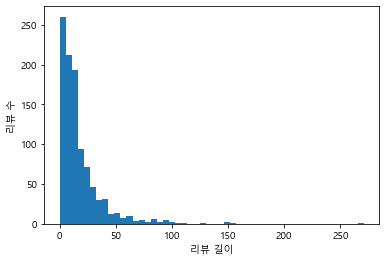

In [255]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('리뷰 길이')
plt.ylabel('리뷰 수')
plt.show()

In [256]:
max_len = sum(map(len, X_train))//len(X_train)
count = len([sentence for sentence in X_train if len(sentence)<=max_len])
print('전체 샘플 중 길이 %s 이하인 샘플 비율: %s'%(max_len, (count/len(X_train)*100)))

전체 샘플 중 길이 17 이하인 샘플 비율: 67.2566371681416


In [257]:
# max_len을 기준으로 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [258]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(
    'best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True
)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(
    X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2
)

Epoch 1/15
11/13 [========================>.....] - ETA: 0s - loss: 0.6717 - acc: 0.6065
Epoch 00001: val_acc improved from -inf to 0.60294, saving model to best_model.h5
13/13 [==============================] - 3s 108ms/step - loss: 0.6648 - acc: 0.6175 - val_loss: 0.6702 - val_acc: 0.6029
Epoch 2/15
12/13 [==========================>...] - ETA: 0s - loss: 0.6265 - acc: 0.6263
Epoch 00002: val_acc improved from 0.60294 to 0.63725, saving model to best_model.h5
13/13 [==============================] - 0s 33ms/step - loss: 0.6266 - acc: 0.6298 - val_loss: 0.6517 - val_acc: 0.6373
Epoch 3/15
11/13 [========================>.....] - ETA: 0s - loss: 0.5384 - acc: 0.7415
Epoch 00003: val_acc did not improve from 0.63725
13/13 [==============================] - 0s 35ms/step - loss: 0.5383 - acc: 0.7442 - val_loss: 0.7594 - val_acc: 0.6373
Epoch 4/15
13/13 [==============================] - ETA: 0s - loss: 0.3977 - acc: 0.8216
Epoch 00004: val_acc did not improve from 0.63725
13/13 [=========

In [ ]:
model.summary()

In [259]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

6/6 [==============================] - 0s 4ms/step - loss: 0.6464 - acc: 0.6111

 테스트 정확도: 0.6111


In [166]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = t.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen=max_len)

    score = float(loaded_model.predict(pad_new))
    if(score>0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score*100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score)*100))

In [167]:
sentiment_predict('너무 맛있어서 토했어요')

65.25% 확률로 긍정 리뷰입니다.


In [168]:
sentiment_predict('너무 맛있어서 쓰레기통에 잘 넣어 놨어요')

81.98% 확률로 긍정 리뷰입니다.


In [175]:
sentiment_predict('감자는 고구마의 친구입니다.')

88.28% 확률로 긍정 리뷰입니다.


In [174]:
sentiment_predict('감자 감자 왕감자 정말 정말 좋아요오오오오 못 다 먹겠죠')

83.98% 확률로 긍정 리뷰입니다.
